In [1]:
# Import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

import seaborn as sns
import pickle
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K
# import helper functions
import sys
# add our pipeline folder to the path to import functions
sys.path.insert(1, '../2_modeling')
from model_helper_no_cache import *
%matplotlib inline

from sklearn.metrics import roc_curve, auc


"""
nb_extensions
https://github.com/ipython-contrib/jupyter_contrib_nbextensions/blob/master/README.md
https://github.com/Jupyter-contrib/jupyter_nbextensions_configurator/blob/master/README.md
"""

'\nnb_extensions\nhttps://github.com/ipython-contrib/jupyter_contrib_nbextensions/blob/master/README.md\nhttps://github.com/Jupyter-contrib/jupyter_nbextensions_configurator/blob/master/README.md\n'

# List the files of saved models


In [2]:
# Path
models_path = '../../efs/models'
checkpoint_path='../../efs/models/Checkpoints/'
training_history_path='../../efs/models/Training_history/'
saved_models_path='../../efs/models/Saved_models/'

In [3]:
os.listdir(checkpoint_path)

['model_Multi_input_sample_size_all_epoch_30_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.ckpt.data-00001-of-00002',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.ckpt.data-00000-of-00002',
 'model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended.ckpt.data-00000-of-00002',
 'model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended.ckpt.index',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.ckpt.index',
 'model_ALL_FEATURES_sample_size_500_epoch_2_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.ckpt.data-00001-of-00002',
 'model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10.ckpt.data-00000-of-00002',
 'checkpoint',
 'model_no_cache_test_sample_size_all_epoch_2_dense_2_n

In [4]:
os.listdir(training_history_path)

['model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.pickle',
 'model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10.pickle',
 'model2_sample_sizeall_epoch50_dense2_losswbc_history_log.csv',
 'model_no_cache_test_sample_size_14000_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv',
 'model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10_history_log.csv',
 'model_Multi_input_sample_size_15000_epoch_10_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.pickle',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv',
 'model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended_history_log.csv',
 'model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_

# Set the parameter

In [5]:
weights='model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10'

csv = '../1_cleaning/metadata_cleaned2.csv'

number_of_images = 'all'

history=weights+'.pickle'

In [6]:
# Create train-test dataset
#name_of_model='model1_sample_sizeall_epoch50_dense2_losswbc'
# Test train split, plus the features that are used to binarize the data
X_train, X_val, y_train_bin, y_val_bin, features = train_test_split_custom(number_of_images, csv)


# Load the model

## Option 1 : load the saved model:

In [8]:
# Load the model
new_model = tf.keras.models.load_model('../../efs/models/Saved_models/' + weights + '.h5', \
                                       custom_objects={'weighted_bce': weighted_bce, 
                                                       'accuracy_on_zero': accuracy_on_zero,
                                                       'accuracy_on_one': accuracy_on_one, 
                                                       'precision_on_1': precision_on_1})

## Option 2:  load the architecture + weights

In [ ]:
# Architecture
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

transfer_layer = vgg.get_layer('block5_pool')

# cutting of the end of the model before the dense layers
conv_model = Model(inputs=vgg.input,
                   outputs=transfer_layer.output)

# freeze VGG
conv_model.trainable = False

num_label = y_train_bin.shape[1]

def create_model():
    # Start a new Keras Sequential model.
    model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    model.add(conv_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.2))
    
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.2))

    model.add(Dense(num_label, activation='sigmoid'))
    
    # Settings
    LR = 1e-5
    optimizer = Adam(lr=LR)
    loss = weighted_bce
    metrics = [accuracy_on_one, accuracy_on_zero]
    
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    return model


new_model=create_model()



In [8]:
# Checkpoint path
# For weights to be saved each epoch
#checkpoint_path = '../../efs/models/Checkpoints/' + weights + '.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Loads the weights from the checkpoint path above
new_model.load_weights(checkpoint_path+weights+'.ckpt')

# Model architecture

In [9]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 184)               9

# Predictions for the test dataset

In [10]:
# Create the datasets
# new_model.load_weights(checkpoint_path)
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [11]:
# Make the predictions
#%%time
# Takes 2:30 with 1000 images, 
# grab the predictions from the valadation ds
predictions_test = new_model.predict(val_ds)
#predictions_train = new_model.predict(train_ds)

# SAVE the prediction
#pickle.dump([predictions_test], open( "predictions.p", "wb" ) )

In [11]:
# Optional step - load the predictions from file
#pickle.dump([predictions_test], open( "predictions.p", "wb" ) )
# Load the prediction
#predictions_test= pickle.load( open( "predictions.p", "rb" ) )

# Evaluations

## Loss plots

In [12]:
# Load the training history
history=pickle.load(open(training_history_path+history, "rb" ))


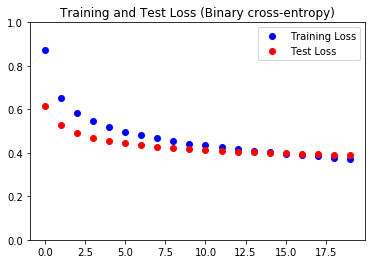

In [13]:
# Plot the training history
plot_training_history_loss(history)

## Model prediction on features that are present in photo

In [14]:
def plot_per_feature_error(predictions, actual, features, diff=False):
    
    """return plot of boxplot of predictions when the feature is active"""
    
    only_ones = np.array([np.where(y_true == 1, pred, np.nan) for y_true, pred in zip(actual,
                                                                                  predictions)])
    pred_df = pd.DataFrame(only_ones)
    
    # Name the classes 
    pred_df.columns = features

    # order the whole dataframe and return the column names
    order = pred_df.median().sort_values().keys()
    fig_dims = (22,10)
    fig, ax = plt.subplots(figsize=fig_dims)
    
    melted=pred_df.melt()
    #melted_with_medians = melted.merge(medians_per_feature, on='variable', how='left')
    #melted_with_medians['avg_prediction']=melted_with_medians['median']>0.5
    #my_pal = {"g", "r"}
    #boxprops = dict(linestyle='-', linewidth=4, color='grey', alpha=.1)
    
    sns.boxplot(x='variable', y='value', data=pred_df.melt(), whis=0, showfliers=False, order=order, boxprops=dict(alpha=.1))
    #sns.boxplot(x='variable', y='value', boxprops=boxprops, data=melted_with_medians, whis=0, hue='avg_prediction', palette=my_pal, showfliers=False, order=order)
    #boxprops=dict(alpha=.3)

    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    
    ax.set_xlabel('Fashion features', fontsize=30)
    ax.set_ylabel('Raw probabilities if the label is ON', fontsize=30)
    ax.set_title('Raw probabilities per feature if the label is ON', fontsize=40)
    ax.set(xticklabels=[])

    
    if diff:
        only_zeros = np.array([np.where(y_true == 0, pred, np.nan) for y_true, pred in zip(actual,
                                                                                  predictions)])
        pred_df2 = pd.DataFrame(only_zeros)
        pred_df2.columns = features
        
        pred_df=pred_df.reindex(pred_df.median().sort_values().index, axis=1)
        pred_df2=pred_df2.reindex(pred_df.median().sort_values().index, axis=1)
        
        
        median_ones=pred_df.median()
        median_zeros=pred_df2.median()
        diff=median_ones-median_zeros
        diff=pd.DataFrame(diff)

        sns.scatterplot(data=diff)

    return fig, ax

In [15]:
len(features)

184

(<Figure size 1584x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f15317658d0>)

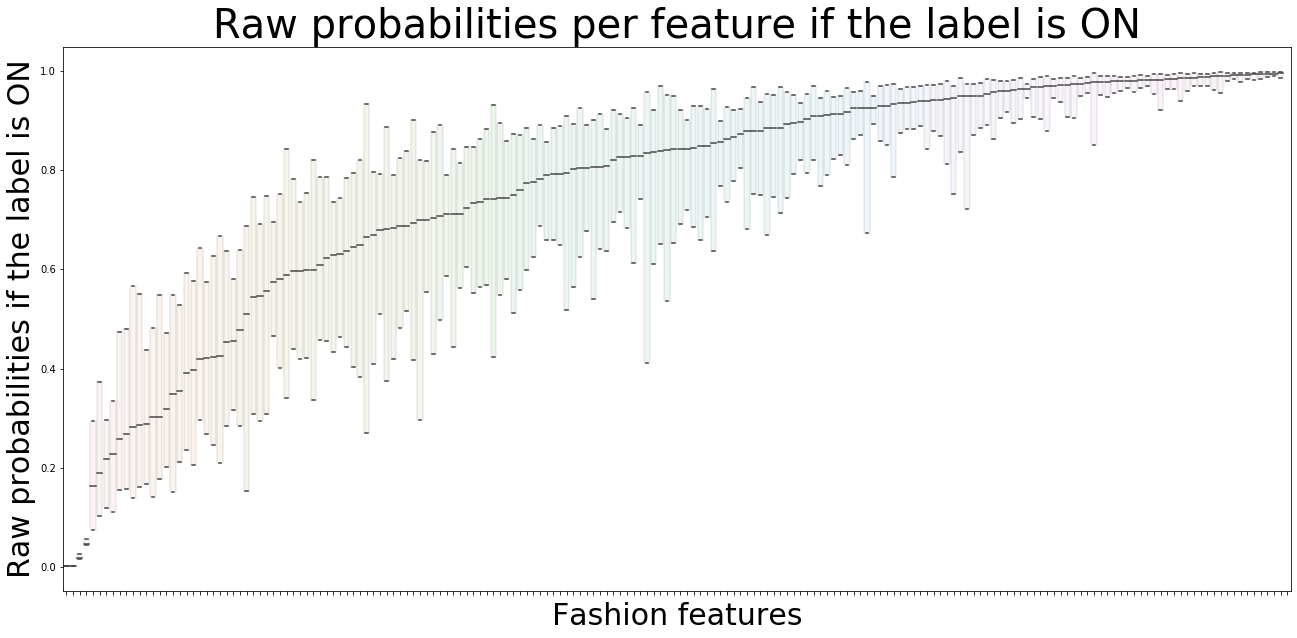

In [16]:
# Plot the predictions on 1s + the differences of medians 
plot_per_feature_error(predictions_test, y_val_bin, features, diff=False)

## Recall on 1, recall on 0

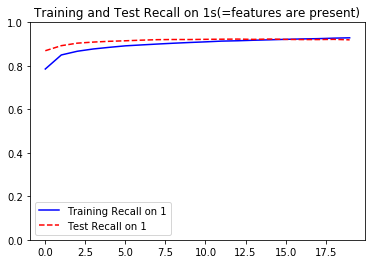

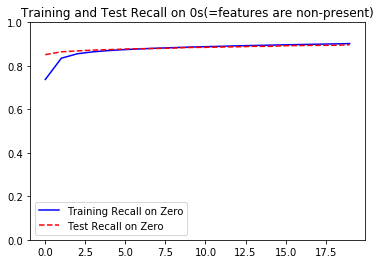

In [17]:
plot_training_history_recall_on_one(history)
plot_training_history_recall_on_zero(history)

# Precision

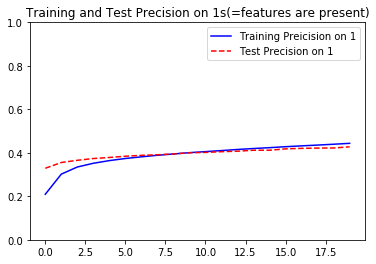

In [18]:
plot_training_history_precision_on_one(history)

## Precision - Recall curve with F1

In [19]:
import copy

[]

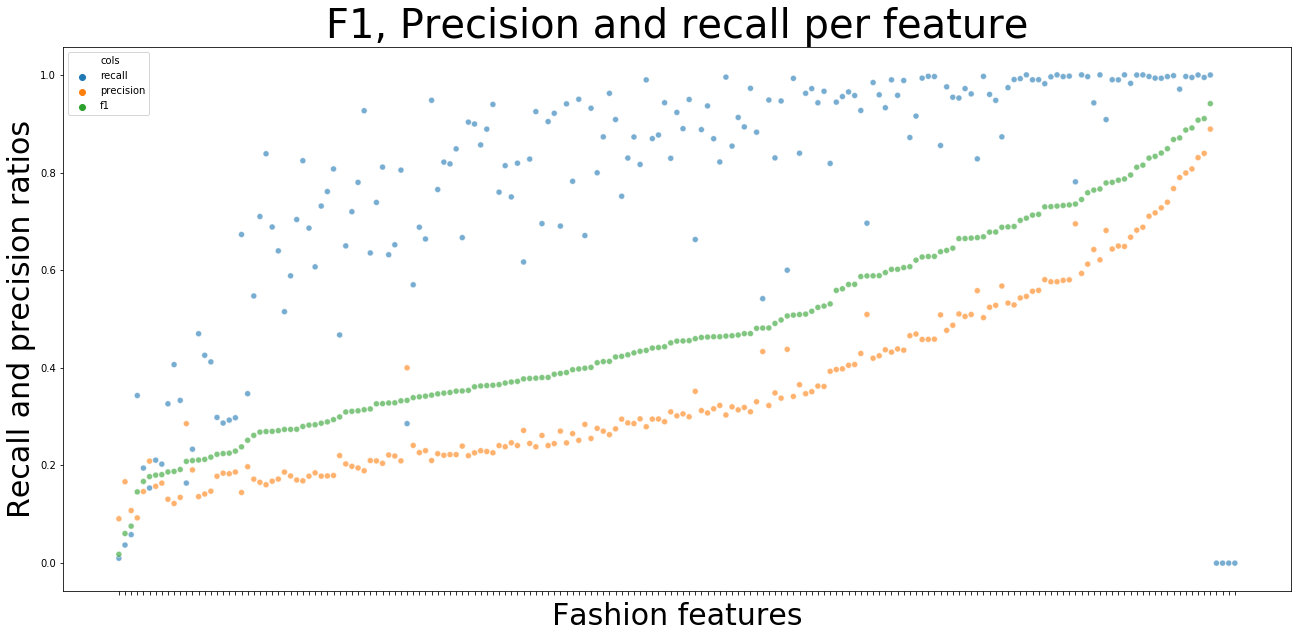

In [20]:

predictions_conv=copy.deepcopy(predictions_test)

predictions_conv[predictions_conv >= 0.5] =1 
predictions_conv[predictions_conv < 0.5] =0


true_pos=np.logical_and(predictions_conv, y_val_bin)
true_pos_df=pd.DataFrame(true_pos)
true_pos_df.columns = features
true_pos_per_feature=true_pos_df.sum(axis=0) 

true_ones=pd.DataFrame(y_val_bin)
true_ones.columns = features
true_ones_per_feature=true_ones.sum(axis=0) 

recall=true_pos_per_feature/true_ones_per_feature
recall_sorted=recall.sort_values()

precision_df=pd.DataFrame(predictions_conv)
precision_df.columns = features
all_1_predictions_per_feature=precision_df.sum(axis=0) 
precision=true_pos_per_feature/all_1_predictions_per_feature


combined=pd.concat([recall, precision], axis=1)
combined.columns= ['recall', 'precision']
#combined=combined.sort_values(by='recall')
combined['features']=combined.index

#F1 Score = 2*(Recall * Precision) / (Recall + Precision)
combined['f1']= 2*combined['recall']*combined['precision']/(recall+precision)
combined=combined.sort_values(by='f1')

combined_melt= combined.melt('features', var_name='cols', value_name='vals')

fig_dims = (22,10)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.scatterplot(x='features', y="vals", hue='cols', data=combined_melt, alpha=0.6)
g.set_xlabel('Fashion features', fontsize=30)
g.set_ylabel('Recall and precision ratios', fontsize=30)
g.set_title('F1, Precision and recall per feature', fontsize=40)
g.set_xticklabels([],rotation=90)


## Make a prediction for an image

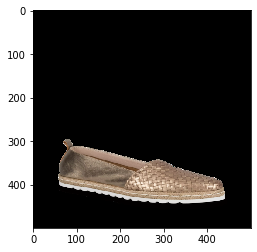

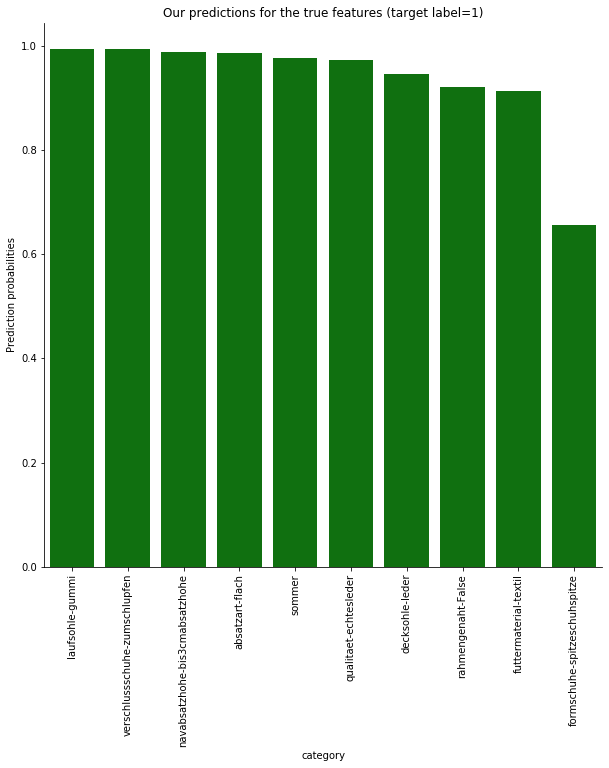

In [22]:
doPrediction(0, features, X_val, y_val_bin, predictions_test)

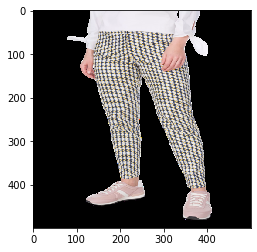

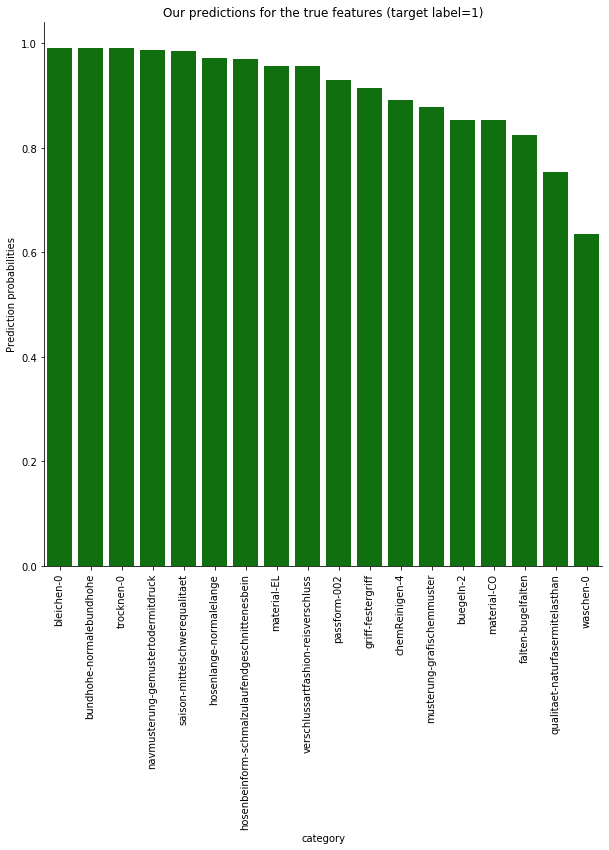

In [23]:
doPrediction(1,features, X_val, y_val_bin, predictions_test)

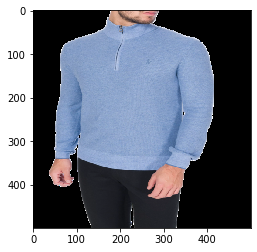

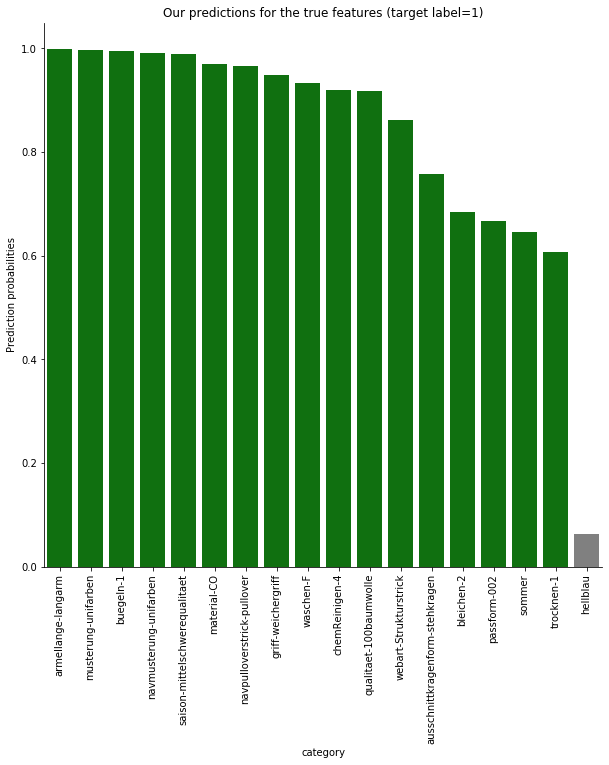

In [24]:
doPrediction(3,features, X_val, y_val_bin, predictions_test)

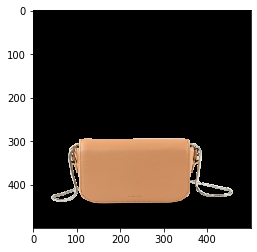

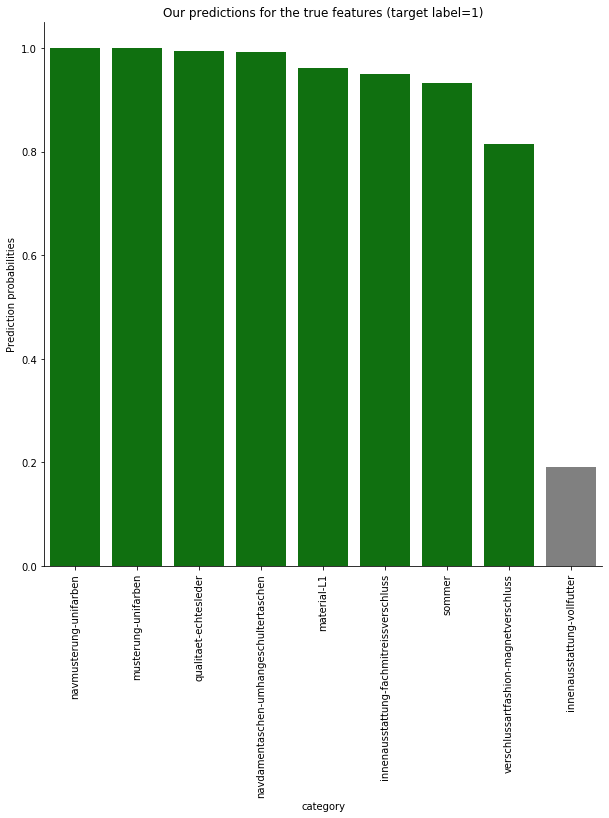

In [25]:
doPrediction(4,features, X_val, y_val_bin, predictions_test)

In [2]:
doPrediction(5,features, X_val, y_val_bin, predictions_test)

NameError: name 'doPrediction' is not defined

## ROC AUC curve

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46903b7780>)

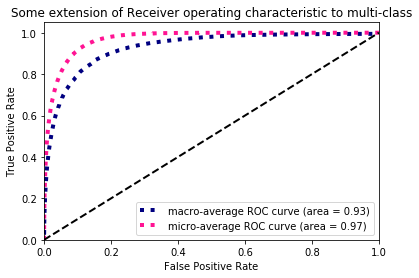

In [26]:
grouped_roc(y_val_bin, predictions_test)

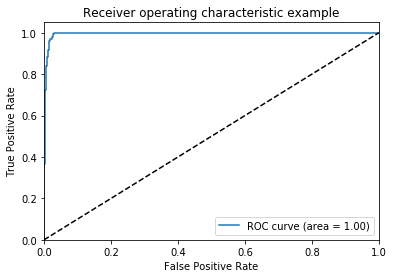

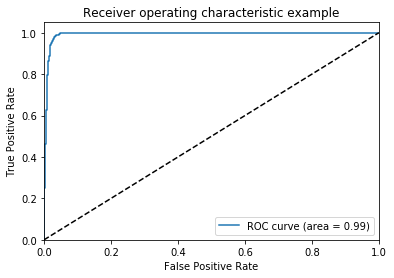

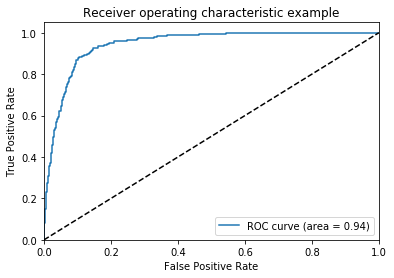

In [27]:
# Plot 3 ROC curves for 3 features
n_classes = y_val_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

    
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], predictions_test[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [28]:
# ROC AUC scores per feature
for i in range(119):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], predictions_test[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_auc

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


{0: 0.9957340508152432,
 1: 0.9928496508735654,
 2: 0.9447238387364374,
 3: 0.9915518471317157,
 4: 0.9578879248028951,
 5: 0.9969690808979246,
 6: 0.7752374067873993,
 7: 0.9661675424387288,
 8: 0.9879121632144526,
 9: 0.8528017778780858,
 10: 0.9579352747564867,
 11: 0.9902697051503154,
 12: 0.9922727406997633,
 13: 0.987149308787534,
 14: 0.9636344022035116,
 15: 0.9919107088464384,
 16: 0.9893501131643744,
 17: 0.9697833775319279,
 18: 0.9326915245402271,
 19: 0.9441695105925203,
 20: 0.8820081290997628,
 21: 0.7994406836922384,
 22: 0.9828800270396223,
 23: 0.9748495652541537,
 24: 0.9221700791609606,
 25: 0.9835632583893646,
 26: 0.8387204986878869,
 27: 0.9654004706287419,
 28: 0.9293710660316256,
 29: 0.9775620299744556,
 30: 0.933419870313074,
 31: 0.981993474921208,
 32: 0.9756150370040663,
 33: 0.936867413537006,
 34: 0.8533383863695039,
 35: 0.780426652419478,
 36: 0.8503538415005532,
 37: 0.9210371584264143,
 38: 0.8428547594491294,
 39: 0.8681180830002048,
 40: 0.86074147

## Flask app 

In [13]:
from flask import Flask

app = Flask(__name__)

@app.route('/')
def entry_page():
    #Jinja template of the webpage
    return render_template('index.html')

@app.route('/predict_object/', methods=['GET', 'POST'])
def render_message():
    
    #Loading CNN model
    #saved_model = 'saved_models/tuned_model_fin.h5'
    #model = load_model(saved_model)
    
    model=new_model
    
    
    try:
        #Get image URL as input
        image_url = request.form['image_url']
        image = io.imread(image_url)
        
        #Apply same preprocessing used while training CNN model
        image_small = st.resize(image, (32,32,3))
        x = np.expand_dims(image_small.transpose(2, 0, 1), axis=0)
        
        #Call classify function to predict the image class using the loaded CNN model
        final,pred_class = classify(x, model)
        print(pred_class)
        print(final)
        
        #Store model prediction results to pass to the web page
        message = "Model prediction: {}".format(pred_class)
        print('Python module executed successfully')
        
    except Exception as e:
        #Store error to pass to the web page
        message = "Error encountered. Try another image. ErrorClass: {}, Argument: {} and Traceback details are: {}".format(e.__class__,e.args,e.__doc__)
        final = pd.DataFrame({'A': ['Error'], 'B': [0]})
        
    #Return the model results to the web page
    return render_template('index.html',
                            message=message,
                            data=final.round(decimals=2),
                            image_url=image_url)

In [1]:
streamlit hello

SyntaxError: invalid syntax (<ipython-input-1-c7a1b683aa76>, line 1)

## Visualizing the channels in the model

In [16]:
# focus on the 7th layer of CNN model
print(new_model.layers[4].input)

Tensor("dropout/Identity:0", shape=(None, 512), dtype=float32)


In [18]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 184)               9

In [26]:
from tensorflow.keras.applications.vgg19 import preprocess_input

In [29]:
from tensorflow.keras import models

In [57]:
new_model2 = VGG19()

In [58]:
new_model2.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [60]:
layer_outputs = [layer.output for layer in new_model2.layers[1:6]] 
# Extracts the outputs of the top 12 layers

activation_model = models.Model(inputs=new_model2.input, outputs=layer_outputs)
# Creates a model that will return these outputs, given the model input

In [61]:
new_model2.input

<tf.Tensor 'input_1_1:0' shape=(None, 224, 224, 3) dtype=float32>

In [37]:
df_test = pd.read_csv('../1_cleaning/metadata_cleaned2.csv')


In [48]:
img_path1=df_test['image_path'][0]

In [46]:
from tensorflow.keras.preprocessing import image

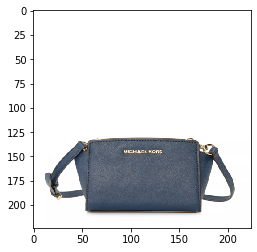

(1, 224, 224, 3)


In [49]:
img = image.load_img(img_path1, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [62]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

In [63]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 224, 224, 64)


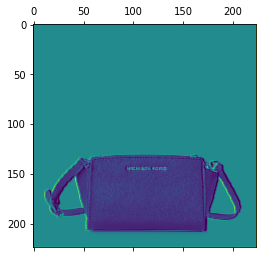

In [64]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

invalid value encountered in true_divide


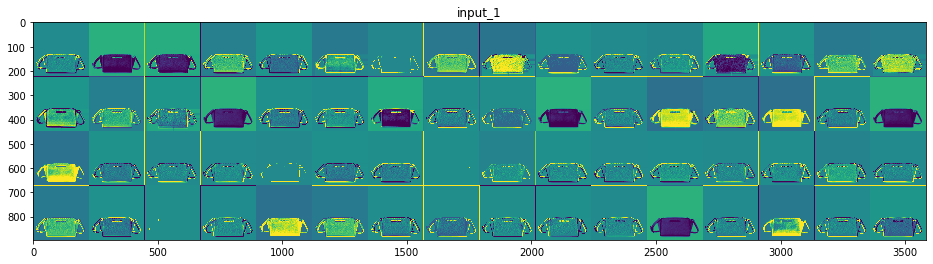

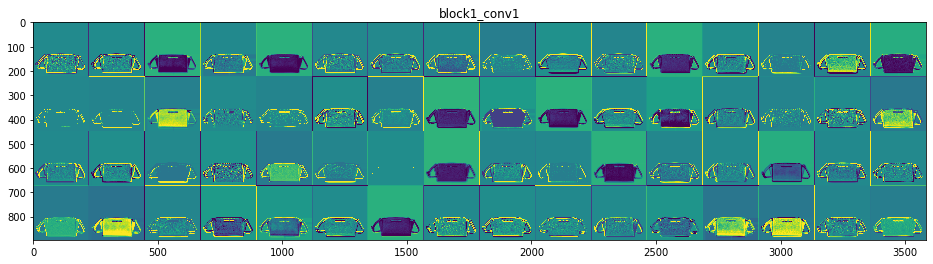

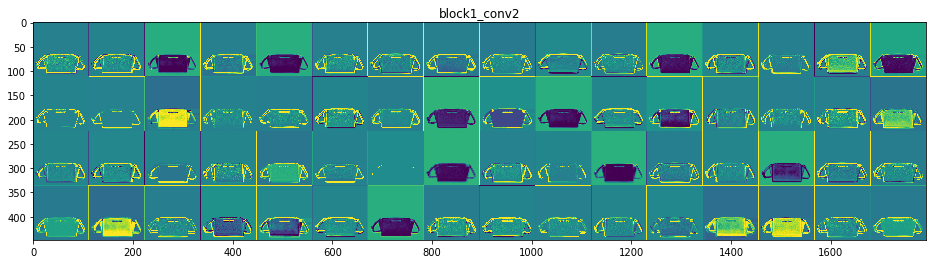

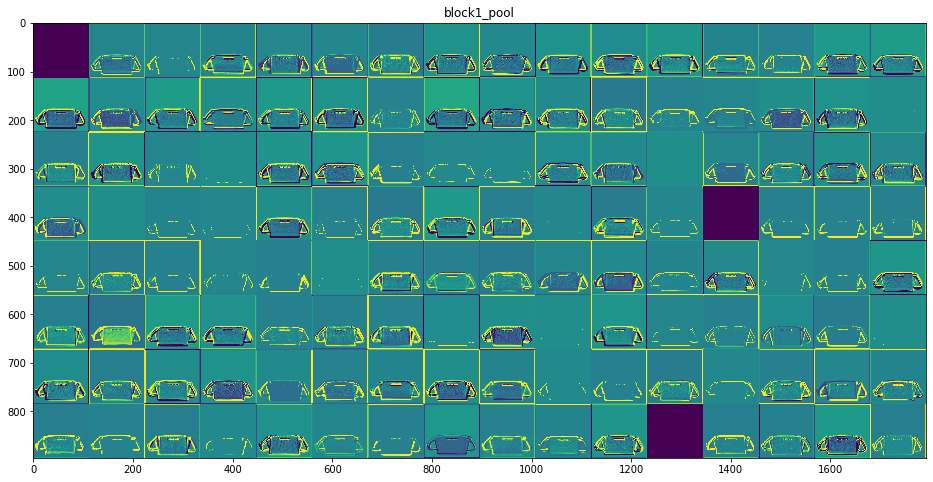

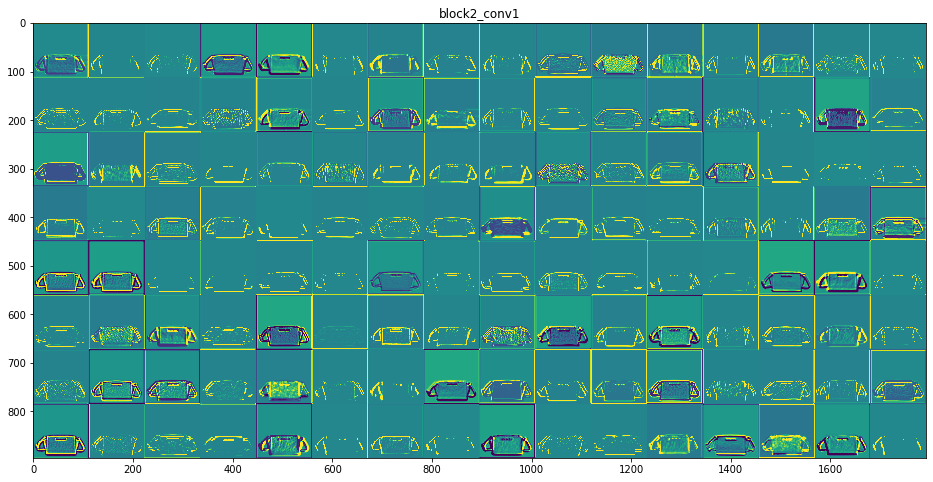

In [67]:
layer_names = []
for layer in new_model2.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [21]:
data_3d=pd.concat([recall,precision], axis=1)

In [22]:

data_3d.rename(columns={0:'recall', 1:'precision'}, inplace=True)
data_3d.shape

(184, 2)

In [23]:
df_clean = pd.read_csv('../1_cleaning/metadata_cleaned2.csv')
df_clean['features'] = df_clean['features'].apply(eval)
list_of_all_features = [item for l in df_clean.features for item in l]
feature_df = pd.DataFrame.from_dict(Counter(list_of_all_features), orient='index').reset_index()
feature_df.rename(columns={'index':'feature', 0:'count'}, inplace=True)


feature_df.sort_values('count', inplace=True)
feature_df['count_frequency'] = np.array(feature_df['count']/np.max(feature_df['count']))
feature_df_simple = feature_df.set_index(keys='feature').drop(labels=['count'], axis=1)

#mergedDf = recall_precision.merge(feature_df_simple, left_index=True, right_index=True)

# Drop the 5 features with no precision
#mergedDf.dropna(inplace = True)


In [61]:
merged_3d = data_3d.merge(feature_df_simple, left_index=True, right_index=True)

In [62]:
merged_3d.shape

(184, 3)

In [63]:
merged_3d.head()

merged_3d.dropna(inplace = True)

In [44]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D(data_3D, labels=None, **kwargs):
    fig_ = plt.figure(figsize=(15,15))
    ax = Axes3D(fig_)
    ax.scatter(data_3D.iloc[:, 0], data_3D.iloc[:, 1], data_3D.iloc[:, 2], c=labels, **kwargs, s=30)
    ax.set_xlabel(data_3D.columns[0])
    ax.set_ylabel(data_3D.columns[1])
    ax.set_zlabel(data_3D.columns[2])
    return ax

def kmeans_clusters_3D(data_, n_clusters):
    km_ = KMeans(n_clusters)
    km_.fit(data_)
    plot_3D(data_, km_.labels_.astype(float))
    return

from sklearn.cluster import KMeans


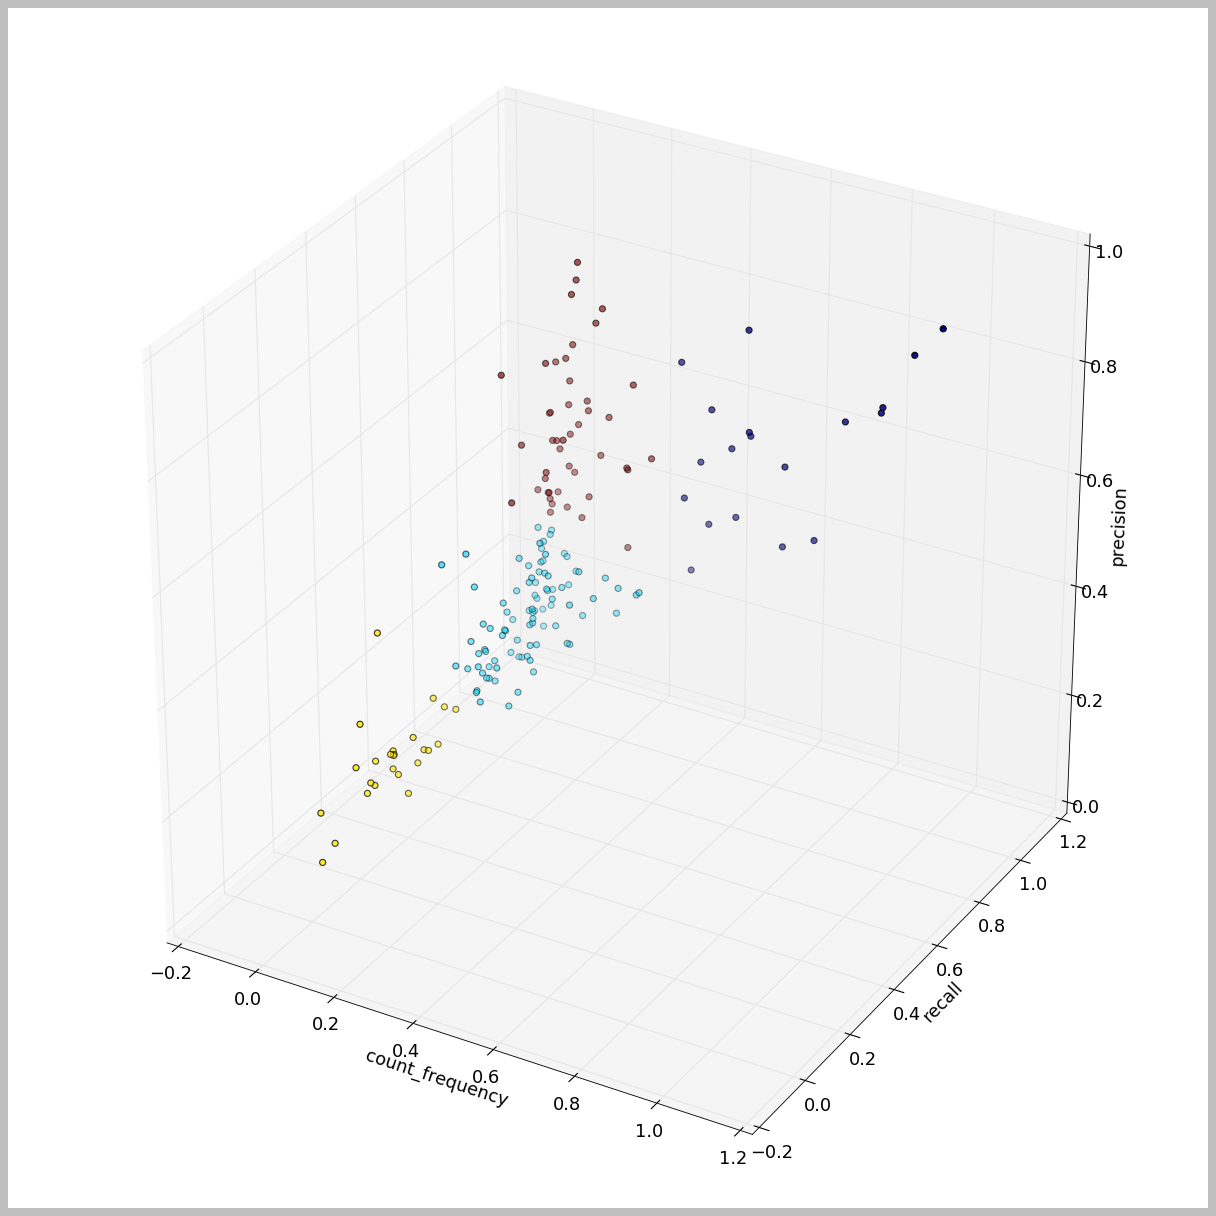

In [64]:
plt.style.use('classic')
plt.rcParams["figure.figsize"] = (20, 10) #Change matplotlib Box Size
plt.rcParams["font.size"] = 16 #Change matplotlib Font Size
kmeans_clusters_3D(merged_3d[['count_frequency','recall','precision']], 4)

In [67]:
#def kmeans_clusters_3D(data_, n_clusters):
 
km_ = KMeans(4)
km_.fit(merged_3d)
#plot_3D(data_, km_.labels_.astype(float))
#return


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [76]:
merged_3d['labels']=km_.labels_

In [77]:
merged_3d.head()

recall  precision  count_frequency  labels
absatzart-blockabsatz  0.996466   0.579055         0.070020       0
absatzart-flach        0.990476   0.528814         0.077282       0
anlass-abend           0.690355   0.270378         0.044112       1
anlass-business        0.908425   0.681319         0.063052       0
anlass-casual          0.952565   0.510373         0.247939       0

In [78]:
import plotly.express as px
fig = px.scatter_3d(merged_3d, x='recall', y='precision', z='count_frequency',color='labels')
fig.show()

In [66]:
merged_3d

recall  precision  \
absatzart-blockabsatz                               0.996466   0.579055   
absatzart-flach                                     0.990476   0.528814   
anlass-abend                                        0.690355   0.270378   
anlass-business                                     0.908425   0.681319   
anlass-casual                                       0.952565   0.510373   
anlass-freizeit                                     0.994667   0.807359   
anthrazit                                           0.010000   0.090909   
armabschluss-manschettenmiteinemknopf               0.889831   0.305677   
armabschluss-mitverstellbarenmanschetten            0.960000   0.524017   
armelform-raglanarmel                               0.343195   0.092652   
armellange-34armlange                               0.829181   0.309840   
armellange-kurzarm                                  0.989765   0.649429   
armellange-langarm                                  0.996720   0.799023   
armellange-ohnearm                                  0.915556   0.469248   
ausschnittkragenform-blusenkragen                   0.751412   0.294900   
ausschnittkragenform-kapuzenkragen                  0.780952   0.694915   
ausschnittkragenform-polokragen                     0.827957   0.557971   
ausschnittkragenform-rundhalsausschnitt             0.990022   0.643372   
ausschnittkragenform-stehkragen                     0.631579   0.221477   
ausschnittkragenform-vausschnitt                    0.873016   0.270270   
beidesaison                                         0.765152   0.224112   
beige                                               0.210884   0.157360   
besonderheiten-abnehmbarerlaengenverstellbarers...  0.965054   0.405192   
besonderheiten-anhaenger                            0.950000   0.251504   
besonderheiten-applikationen                        0.406593   0.122112   
besonderheiten-fransen                              0.927039   0.429423   
besonderheiten-glitzerapplikationen                 0.347032   0.197403   
besonderheiten-goldfarbenedetails                   0.955595   0.397929   
besonderheiten-mitschoenerraffung                   0.639535   0.172144   
besonderheiten-mitunterkleid                        0.635294   0.210117   
...                                                      ...        ...   
taschen-schragertascheneingriff                     0.855297   0.508449   
trocknen-0                                          0.999736   0.830523   
trocknen-1                                          0.821321   0.220921   
trocknen-2                                          0.326316   0.130802   
verschlussartfashion-druckknopfe                    0.750000   0.246429   
verschlussartfashion-knopfe                         0.839535   0.365385   
verschlussartfashion-magnetverschluss               0.939516   0.225994   
verschlussartfashion-reisverschluss                 0.973835   0.532648   
verschlussartfashion-riegelverschluss               0.887850   0.312500   
verschlussartfashion-schnurung                      0.570093   0.241107   
verschlussschuhe-reissverschluss                    0.932692   0.436937   
verschlussschuhe-zumschlupfen                       0.975460   0.476762   
verschlussschuhe-zumschnuren                        0.982639   0.667453   
waschen-0                                           0.882622   0.330479   
waschen-1                                           0.923077   0.301676   
waschen-2                                           0.688453   0.167817   
waschen-3                                           0.298387   0.177885   
waschen-4                                           0.779817   0.194954   
waschen-F                                           0.988430   0.436178   
waschen-G                                           0.514925   0.186486   
webart-Strukturstrick                               0.649718   0.203180   
webart-ausjersey                                    0.966395   0.361799   
weba